In [1]:
import os
import json
import tempfile
from operator import itemgetter
from warnings import filterwarnings

import mlflow
import sqlite3
import numpy as np
import pandas as pd
from scipy.stats import randint, uniform, loguniform
from sklearn import set_config
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from xgboost.sklearn import XGBRegressor

from src.evaluation import *
from src.experiments import optimize_params, grid_search, pipeline_recomposition_with_rfe
from src.feature_engineering import (DataEnhancer, AnomaliesMarker, ColumnSelector,
                                     return_function_transformers)
from src.utils import (return_train_test_data, return_models_with_param_grids,
                       load_feature_selection_estimators, return_feature_set)
from src.data_visuals import histplots_grid

In [2]:
mlflow.set_tracking_uri("sqlite:///mlruns.db")

np.set_printoptions(suppress=True, formatter={"float_kind":"{:0.5f}".format})
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

set_config(transform_output="pandas")
ConvergenceWarning("ignore")
filterwarnings("ignore")

SEED = 42
N_TEST = 4*144*7 # test set size = 4 weeks ~ 20,4%

# validation set size = 3 weeks ~ 19.6% of train set)
tss_params = {"n_splits": 3, "max_train_size": None, "test_size": 3*7*144}
TSS = TimeSeriesSplit(**tss_params)

METRICS_COLS = ["metrics.best_rmse",
                "metrics.corresp_mae",
                "metrics.corresp_medae",
                "metrics.corresp_r2",
                "metrics.best_mae",
                "metrics.best_medae",
                "metrics.best_rmse_train"]

In [3]:
file_path = os.path.join("data", "energydata_complete.csv")
data = pd.read_csv(file_path)

data.date = pd.to_datetime(data.date, format="%d-%m-%Y %H:%M")
data.set_index("date", inplace=True)

# target variable:
data["Appliances_24"] = data.Appliances

# shifting the remaining columns back by 24h relative to the index and target variable:
data[data.columns[:-1]] = data[data.columns[:-1]].shift(24*6)

enhancer = DataEnhancer(data)
enhanced_data = (enhancer
                 .dropna()
                 .drop_features(["T6", "RH_6"])
                 .add_datetime_features()
                 .mark_high_values()
                 .mark_empty_house_days()
                 .data)

# conversion of data types for compatibility and performance optimization:
# - converting numeric columns to float to prevent MLflow warnings with integer 0/1 columns
# - converting object columns to categorical to resolve dtype issues with XGBoost
num_type = enhanced_data.select_dtypes(np.number).columns
object_type = ["day_of_week", "time_of_day"]
enhanced_data[num_type] = enhanced_data[num_type].astype("float")
enhanced_data[object_type] = enhanced_data[object_type].astype("category")

# saving base features list for further usage
base_features = enhanced_data.columns.to_list()
base_features.remove("Appliances_24")

enhanced_data.head(2)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances_24,day_of_week,hour,minute,time_of_day,week_of_year,day_of_year,is_holiday,is_weekend,is_high_usage,is_empty_house
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-12 17:00:00,60.00,30.00,19.89,47.60,19.20,44.79,19.79,44.73,19.00,45.57,17.17,55.20,17.20,41.63,18.20,48.90,17.03,45.53,6.60,733.50,92.00,7.00,63.00,5.30,13.28,13.28,60.00,Tuesday,17.00,0.00,evening,2.00,12.00,0.00,0.00,0.00,0.00
2016-01-12 17:10:00,60.00,30.00,19.89,46.69,19.20,44.72,19.79,44.79,19.00,45.99,17.17,55.20,17.20,41.56,18.20,48.86,17.07,45.56,6.48,733.60,92.00,6.67,59.17,5.20,18.61,18.61,60.00,Tuesday,17.00,10.00,evening,2.00,12.00,0.00,0.00,0.00,0.00


# Prediction benchmarks

For reference points in making predictions, the following options were adopted:

* Values from the previous week (same weekday and time).
* Historical averages for the specific hour and minute, calculated using training data.
* A simple linear regression model was applied to the original dataset, which has been enhanced with basic datetime features (as above), data scaling and a logarithmic transformation of the target variable.

The scores achieved are presented below.

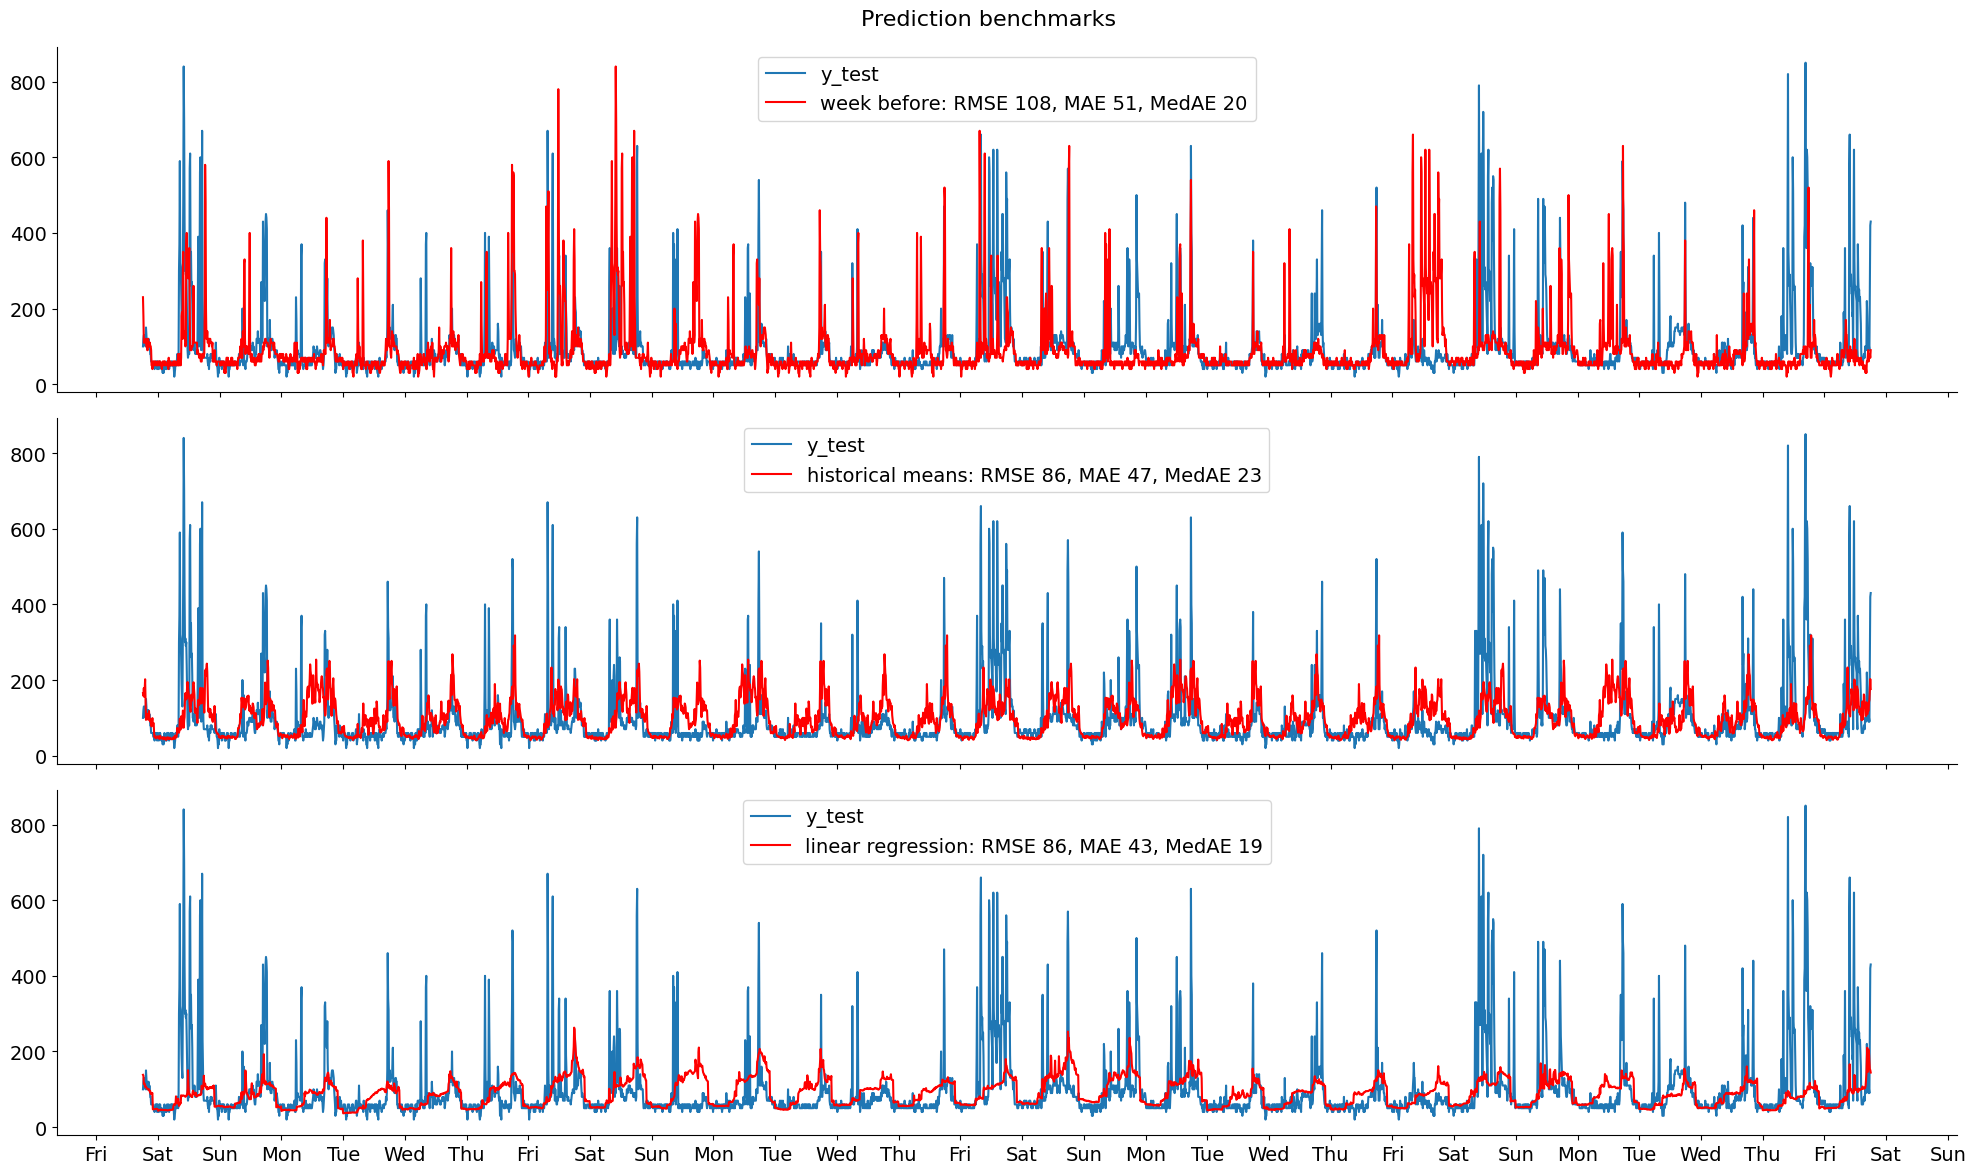

In [4]:
prediction_benchmarks(enhanced_data, N_TEST)

# Experiments

## Feature engineering

In [5]:
# mlflow.create_experiment(name="Feature_engineering")
mlflow.set_experiment("Feature_engineering")

<Experiment: artifact_location='/home/kasia/DS/energy/Appliances_energy_prediction/mlruns/1', creation_time=1707986249749, experiment_id='1', last_update_time=1707986249749, lifecycle_stage='active', name='Feature_engineering', tags={}>

### Data augmentation with lagged and window features

Data version as presented above, with different models and sets of additional columns, was used (based on *0_data_exploration.ipynb*). Two regularized linear algorithms and four ensembles (including two that use boosting) were applied.

During optimization using pipelines, in addition to model hyperparameters, transformations of certain features and of the target variable were also tested. The logarithm transformation were applied to all skewed features at once for convenience, although it's only useful for linear models.

To save and compare the results, different sets of columns were applied in a loop, saving the list of columns as a parent run artifact and input examples using MLflow signatures for the models.

In [6]:
weather_features = ["T_out", "RH_out", "Press_mm_hg",
                    "Windspeed", "Visibility", "Tdewpoint"]

house_environ_features = ["T1", "RH_1", "T2", "RH_2", "T3", "RH_3", "T4", "RH_4",
                          "T5", "RH_5", "T7", "RH_7", "T8", "RH_8", "T9", "RH_9"]

energy_features = ["Appliances", "lights"]

enhanced_data = (enhancer
                 .add_lagged_features(
                     features=energy_features,
                     lags=[1, 2, 3, 72, 144]
                 )
                 .add_lagged_features(
                     features=house_environ_features,
                     lags=[2, 3, 6, 144]
                 )
                 .add_lagged_features(
                     features=weather_features,
                     lags=[2, 8, 72, 144]
                 )
                 .add_moving_average(
                     features=energy_features,
                     windows=[2, 3, 6, 18, 72, 144]
                 )
                 .add_moving_average(
                     features=house_environ_features + weather_features,
                     windows=[6, 72, 144]
                 )
                 .add_moving_sum(
                     features=energy_features,
                     windows=[2, 3, 6, 18, 72, 144]
                 )
                 .dropna()
                 .data)

to_log_features = [col for col in enhanced_data.columns if any(
    word in col for word in ["Appliances", "lights", "Windspeed"]
)]
to_log_features.remove("Appliances_24") # target variable

enhanced_data[to_log_features] = np.log1p(enhanced_data[to_log_features])

X_train, X_test, y_train, y_test = return_train_test_data(enhanced_data,
                                                          N_TEST,
                                                          xy=True)
X_train.head(2)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,day_of_week,hour,minute,time_of_day,week_of_year,day_of_year,is_holiday,is_weekend,is_high_usage,is_empty_house,lag_Appliances_1,lag_Appliances_2,lag_Appliances_3,lag_Appliances_72,lag_Appliances_144,lag_lights_1,lag_lights_2,lag_lights_3,lag_lights_72,lag_lights_144,lag_T1_2,lag_T1_3,lag_T1_6,lag_T1_144,lag_RH_1_2,lag_RH_1_3,lag_RH_1_6,lag_RH_1_144,lag_T2_2,lag_T2_3,lag_T2_6,lag_T2_144,lag_RH_2_2,lag_RH_2_3,lag_RH_2_6,lag_RH_2_144,lag_T3_2,lag_T3_3,lag_T3_6,lag_T3_144,lag_RH_3_2,lag_RH_3_3,lag_RH_3_6,lag_RH_3_144,lag_T4_2,lag_T4_3,lag_T4_6,lag_T4_144,lag_RH_4_2,lag_RH_4_3,lag_RH_4_6,lag_RH_4_144,lag_T5_2,lag_T5_3,lag_T5_6,lag_T5_144,lag_RH_5_2,lag_RH_5_3,lag_RH_5_6,lag_RH_5_144,lag_T7_2,lag_T7_3,lag_T7_6,lag_T7_144,lag_RH_7_2,lag_RH_7_3,lag_RH_7_6,lag_RH_7_144,lag_T8_2,lag_T8_3,lag_T8_6,lag_T8_144,lag_RH_8_2,lag_RH_8_3,lag_RH_8_6,lag_RH_8_144,lag_T9_2,lag_T9_3,lag_T9_6,lag_T9_144,lag_RH_9_2,lag_RH_9_3,lag_RH_9_6,lag_RH_9_144,lag_T_out_2,lag_T_out_8,lag_T_out_72,lag_T_out_144,lag_RH_out_2,lag_RH_out_8,lag_RH_out_72,lag_RH_out_144,lag_Press_mm_hg_2,lag_Press_mm_hg_8,lag_Press_mm_hg_72,lag_Press_mm_hg_144,lag_Windspeed_2,lag_Windspeed_8,lag_Windspeed_72,lag_Windspeed_144,lag_Visibility_2,lag_Visibility_8,lag_Visibility_72,lag_Visibility_144,lag_Tdewpoint_2,lag_Tdewpoint_8,lag_Tdewpoint_72,lag_Tdewpoint_144,mov_av_Appliances_2,mov_av_Appliances_3,mov_av_Appliances_6,mov_av_Appliances_18,mov_av_Appliances_72,mov_av_Appliances_144,mov_av_lights_2,mov_av_lights_3,mov_av_lights_6,mov_av_lights_18,mov_av_lights_72,mov_av_lights_144,mov_av_T1_6,mov_av_T1_72,mov_av_T1_144,mov_av_RH_1_6,mov_av_RH_1_72,mov_av_RH_1_144,mov_av_T2_6,mov_av_T2_72,mov_av_T2_144,mov_av_RH_2_6,mov_av_RH_2_72,mov_av_RH_2_144,mov_av_T3_6,mov_av_T3_72,mov_av_T3_144,mov_av_RH_3_6,mov_av_RH_3_72,mov_av_RH_3_144,mov_av_T4_6,mov_av_T4_72,mov_av_T4_144,mov_av_RH_4_6,mov_av_RH_4_72,mov_av_RH_4_144,mov_av_T5_6,mov_av_T5_72,mov_av_T5_144,mov_av_RH_5_6,mov_av_RH_5_72,mov_av_RH_5_144,mov_av_T7_6,mov_av_T7_72,mov_av_T7_144,mov_av_RH_7_6,mov_av_RH_7_72,mov_av_RH_7_144,mov_av_T8_6,mov_av_T8_72,mov_av_T8_144,mov_av_RH_8_6,mov_av_RH_8_72,mov_av_RH_8_144,mov_av_T9_6,mov_av_T9_72,mov_av_T9_144,mov_av_RH_9_6,mov_av_RH_9_72,mov_av_RH_9_144,mov_av_T_out_6,mov_av_T_out_72,mov_av_T_out_144,mov_av_RH_out_6,mov_av_RH_out_72,mov_av_RH_out_144,mov_av_Press_mm_hg_6,mov_av_Press_mm_hg_72,mov_av_Press_mm_hg_144,mov_av_Windspeed_6,mov_av_Windspeed_72,mov_av_Windspeed_144,mov_av_Visibility_6,mov_av_Visibility_72,mov_av_Visibility_144,mov_av_Tdewpoint_6,mov_av_Tdewpoint_72,mov_av_Tdewpoint_144,mov_sum_Appliances_2,mov_sum_Appliances_3,mov_sum_Appliances_6,mov_sum_Appliances_18,mov_sum_Appliances_72,mov_sum_Appliances_144,mov_sum_lights_2,mov_sum_lights_3,mov_sum_lights_6,mov_sum_lights_18,mov_sum_lights_72,mov_sum_lights_144
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-13 17:00:00,4.11,0.00,20.07,42.83,19.00,42.42,19.79,44.70,19.26,42.56,17.60,50.90,18.14,37.91,18.60,45.79,17.10,43.26,6.50,744.20,75.00,2.08,29.00,2.30,36.47,36.47,Wednesday,17.00,0.00,evening,2.00,13.00,0.00,0.00,0.00,0.00,3.71,3.71,3.71,3.93,4.11,0.00,0.00,0.00,0.00,3.43,20.10,20.10,20.10,19.89,43.16,43.43,43.79,47.60,19.04,19.10,19.20,19.20,42.53,42.59,42.72,44.79,19.82,19.89,19.89,19.79,44.73,44.79,44.70,44.73,19.29,19.39,19.60,19.00,42.59,42.59,42.86,45.57,17.60,17.60,17.70,17.17,50.97,51.00,51.00,55.20,18.24,18.38,18.53,17.20,37.95,38.00,38.25,41.63,18.70,18.70,18.79,18.20,45.72,45.79,45.98,48.90,17.10,17.20,17.20,17.03,43.40,43.53,43.79,45.53,6.43,6.50,5.00,6.60,77.33,80.00,91.00,92.00,744.10,743.87,739.90,733.50,1.95,1.67,1.79,2.08,32.67,40.00,40.00,63.00,2.70,3.30,3.60,5.30,3.93,3.86,3.83,4

Time series split scheme (test size - 3 weeks, 19.6% of train set):

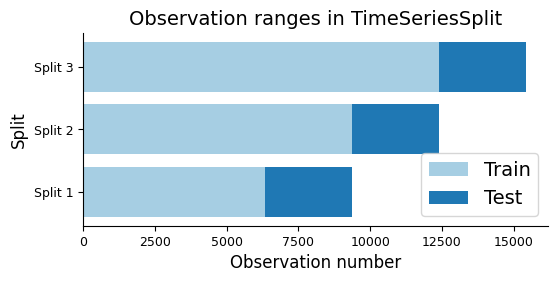

In [7]:
time_series_split(TSS, X_train)

Creating column sets to test:

In [8]:
appliances_lagged = [col for col in enhanced_data.columns
                     if "Appliances" in col and "lag" in col]
appliances_windows = [col for col in enhanced_data.columns
                      if "Appliances" in col and "mov" in col]
appliances = appliances_lagged + appliances_windows

lights_lagged = [col for col in enhanced_data.columns
                 if "lights" in col and "lag" in col]
lights_windows = [col for col in enhanced_data.columns
                  if "lights" in col and "mov" in col]
lights = lights_lagged + lights_windows

house_environ = [col for col in enhanced_data.columns
                 if ("T1" in col or "RH" in col)
                 and ("lag" in col or "mov" in col)]

weather = [col for col in enhanced_data.columns
           if any(feature in col for feature in weather_features)
           and ("lag" in col or "mov" in col)]

feature_sets_to_test = [
    [],
    appliances_lagged,
    appliances_windows,
    appliances,
    appliances + lights_lagged,
    appliances + lights_windows,
    appliances + lights,
    appliances + lights + house_environ,
    appliances + lights + weather,
    appliances + house_environ,
    appliances + weather
]

Creating data preprocessor and target transformers:

In [9]:
day_encoder, time_encoder, hour_encoder, log_transformer, sqrt_transformer = return_function_transformers()
target_transformations = [log_transformer, sqrt_transformer, None]

not_scale_features = ["is_holiday", "is_weekend", "is_high_usage", "is_empty_house"]

preprocessor = ColumnTransformer([
    ("day", day_encoder, ["day_of_week"]),
    ("time", time_encoder, ["time_of_day"]),
    ("hour", hour_encoder, ["hour"]),
    ("pass", "passthrough", not_scale_features)
    ],
                                 remainder=StandardScaler(),
                                 verbose_feature_names_out=False)

preprocessor.fit_transform(X_train).head(2)

,day_of_week_sin,day_of_week_cos,time_of_day_sin,time_of_day_cos,hour_sin,hour_cos,is_holiday,is_weekend,is_high_usage,is_empty_house,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,minute,week_of_year,day_of_year,lag_Appliances_1,lag_Appliances_2,lag_Appliances_3,lag_Appliances_72,lag_Appliances_144,lag_lights_1,lag_lights_2,lag_lights_3,lag_lights_72,lag_lights_144,lag_T1_2,lag_T1_3,lag_T1_6,lag_T1_144,lag_RH_1_2,lag_RH_1_3,lag_RH_1_6,lag_RH_1_144,lag_T2_2,lag_T2_3,lag_T2_6,lag_T2_144,lag_RH_2_2,lag_RH_2_3,lag_RH_2_6,lag_RH_2_144,lag_T3_2,lag_T3_3,lag_T3_6,lag_T3_144,lag_RH_3_2,lag_RH_3_3,lag_RH_3_6,lag_RH_3_144,lag_T4_2,lag_T4_3,lag_T4_6,lag_T4_144,lag_RH_4_2,lag_RH_4_3,lag_RH_4_6,lag_RH_4_144,lag_T5_2,lag_T5_3,lag_T5_6,lag_T5_144,lag_RH_5_2,lag_RH_5_3,lag_RH_5_6,lag_RH_5_144,lag_T7_2,lag_T7_3,lag_T7_6,lag_T7_144,lag_RH_7_2,lag_RH_7_3,lag_RH_7_6,lag_RH_7_144,lag_T8_2,lag_T8_3,lag_T8_6,lag_T8_144,lag_RH_8_2,lag_RH_8_3,lag_RH_8_6,lag_RH_8_144,lag_T9_2,lag_T9_3,lag_T9_6,lag_T9_144,lag_RH_9_2,lag_RH_9_3,lag_RH_9_6,lag_RH_9_144,lag_T_out_2,lag_T_out_8,lag_T_out_72,lag_T_out_144,lag_RH_out_2,lag_RH_out_8,lag_RH_out_72,lag_RH_out_144,lag_Press_mm_hg_2,lag_Press_mm_hg_8,lag_Press_mm_hg_72,lag_Press_mm_hg_144,lag_Windspeed_2,lag_Windspeed_8,lag_Windspeed_72,lag_Windspeed_144,lag_Visibility_2,lag_Visibility_8,lag_Visibility_72,lag_Visibility_144,lag_Tdewpoint_2,lag_Tdewpoint_8,lag_Tdewpoint_72,lag_Tdewpoint_144,mov_av_Appliances_2,mov_av_Appliances_3,mov_av_Appliances_6,mov_av_Appliances_18,mov_av_Appliances_72,mov_av_Appliances_144,mov_av_lights_2,mov_av_lights_3,mov_av_lights_6,mov_av_lights_18,mov_av_lights_72,mov_av_lights_144,mov_av_T1_6,mov_av_T1_72,mov_av_T1_144,mov_av_RH_1_6,mov_av_RH_1_72,mov_av_RH_1_144,mov_av_T2_6,mov_av_T2_72,mov_av_T2_144,mov_av_RH_2_6,mov_av_RH_2_72,mov_av_RH_2_144,mov_av_T3_6,mov_av_T3_72,mov_av_T3_144,mov_av_RH_3_6,mov_av_RH_3_72,mov_av_RH_3_144,mov_av_T4_6,mov_av_T4_72,mov_av_T4_144,mov_av_RH_4_6,mov_av_RH_4_72,mov_av_RH_4_144,mov_av_T5_6,mov_av_T5_72,mov_av_T5_144,mov_av_RH_5_6,mov_av_RH_5_72,mov_av_RH_5_144,mov_av_T7_6,mov_av_T7_72,mov_av_T7_144,mov_av_RH_7_6,mov_av_RH_7_72,mov_av_RH_7_144,mov_av_T8_6,mov_av_T8_72,mov_av_T8_144,mov_av_RH_8_6,mov_av_RH_8_72,mov_av_RH_8_144,mov_av_T9_6,mov_av_T9_72,mov_av_T9_144,mov_av_RH_9_6,mov_av_RH_9_72,mov_av_RH_9_144,mov_av_T_out_6,mov_av_T_out_72,mov_av_T_out_144,mov_av_RH_out_6,mov_av_RH_out_72,mov_av_RH_out_144,mov_av_Press_mm_hg_6,mov_av_Press_mm_hg_72,mov_av_Press_mm_hg_144,mov_av_Windspeed_6,mov_av_Windspeed_72,mov_av_Windspeed_144,mov_av_Visibility_6,mov_av_Visibility_72,mov_av_Visibility_144,mov_av_Tdewpoint_6,mov_av_Tdewpoint_72,mov_av_Tdewpoint_144,mov_sum_Appliances_2,mov_sum_Appliances_3,mov_sum_Appliances_6,mov_sum_Appliances_18,mov_sum_Appliances_72,mov_sum_Appliances_144,mov_sum_lights_2,mov_sum_lights_3,mov_sum_lights_6,mov_sum_lights_18,mov_sum_lights_72,mov_sum_lights_144
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-13 17:00:00,0.97,-0.22,-0.95,0.31,-0.97,-0.26,0.00,0.00,0.00,0.00,-0.29,-0.58,-0.89,0.79,-0.42,0.55,-1.20,1.70,-0.59,0.86,-1.05,-0.06,-0.91,0.58,-1.71,0.57,-1.18,0.45,0.16,-1.47,-0.52,1.07,-0.77,-0.12,0.79,0.79,-1.46,-1.70,-1.74,-0.89,-0.89,-0.89,-0.56,-0.29,-0.58,-0.58,-0.58,-0.58,2.18,-0.87,-0.87,-0.87,-1.03,0.88,0.96,1.06,2.09,-0.39,-0.35,-0.29,-0.29,0.58,0.60,0.64,1.23,-1.17,-1.13,-1.13,-1.18,1.71,1.73,1.70,1.66,-0.57,-0.50,-0.37,-0.76,0.87,0.87,0.93,1.53,-1.05,-1.05,-0.97,-1.37,-0.05,-0.04,-0.05,0.43,-0.84,-0.76,-0.66,-1.48,0.59,0.60,0.65,1.29,-1.65,-1.65,-1.59,-1.90,0.56,0.57,0.61,1.14,-1.18,-1.11,-1.11,-1.20,0.49,0.52,0.59,1.00,0.14,0.16,-0.20,0.18,-0.34,-0.14,0.71,0.79,-1.48,-1.51,-2.01,-2.78,0.81,0.26,0.49,1.06,-0.48,0.10,0.11,1.94,-0.

Creating predefined models instances and parameters grids:

In [10]:
for_linear_preprocessor = {
    "regressor__preprocessor__day": [OneHotEncoder(sparse_output=False, drop="first"),
                                     day_encoder],
    "regressor__preprocessor__time": [OneHotEncoder(sparse_output=False, drop="first"),
                                      time_encoder],
    "regressor__preprocessor__hour": [hour_encoder, StandardScaler()],
    "transformer": target_transformations
}

for_tree_preprocessor = {
    "regressor__preprocessor__day": [OneHotEncoder(sparse_output=False),
                                     day_encoder],
    "regressor__preprocessor__time": [OneHotEncoder(sparse_output=False),
                                      time_encoder],
    "regressor__preprocessor__hour": [hour_encoder, "passthrough"],
    "regressor__preprocessor__remainder": ["passthrough"],
    "transformer": target_transformations
}

In [11]:
models = [model.set_params(random_state=SEED) for model in [ElasticNet(max_iter=5000),
                                                            Ridge(),
                                                            ExtraTreesRegressor(n_jobs=-1),
                                                            HistGradientBoostingRegressor(),
                                                            RandomForestRegressor(n_jobs=-1),
                                                            XGBRegressor()]]
models_param_grids = [
    {
        "regressor__model__alpha": loguniform(1e-2, 1e2),
        "regressor__model__l1_ratio": uniform(0, 1)
    },
    {
        "regressor__model__alpha": loguniform(1e-3, 1e2)
    },
    {
        "regressor__model__n_estimators": randint(100, 200),
        "regressor__model__max_depth": randint(3, 10),
        "regressor__model__min_samples_leaf": randint(5, 100)
    },
    {
        "regressor__model__learning_rate": loguniform(1e-4, 1e0),
        "regressor__model__max_depth": randint(3, 10),
        "regressor__model__min_samples_leaf": randint(5, 100)
    },
    {
        "regressor__model__n_estimators": randint(100, 200),
        "regressor__model__max_depth": randint(3, 10),
        "regressor__model__min_samples_leaf": randint(5, 100)
    },
    {
        "regressor__model__n_estimators": randint(100, 200),
        "regressor__model__max_depth": randint(3, 10),
        "regressor__model__subsample": uniform(0.6, 0.4),
        "regressor__model__colsample_bytree": uniform(0.3, 0.7),
        "regressor__model__min_child_weight": randint(5, 100),
        "regressor__model__learning_rate": loguniform(1e-3, 1e0),
        "regressor__model__gamma": loguniform(1e-3, 1e0),
        "regressor__model__reg_lambda": loguniform(1e-3, 1e1)
    }
]

models_with_params = return_models_with_param_grids(models,
                                                    models_param_grids,
                                                    for_linear_preprocessor,
                                                    for_tree_preprocessor)

Running experiment:

In [16]:
for i, feature_set in enumerate(feature_sets_to_test):
    
    features = base_features + feature_set
    X_train_selected = X_train[features]
    X_test_selected = X_test[features]
    
    with mlflow.start_run(run_name=f"Lagged_windows_set_{i}",
                          tags={"level": "parent",
                                "n_iter": i,
                                "test" : "lags_windows"}) as parent_run:

        with tempfile.NamedTemporaryFile(mode="w+", suffix=".json") as tmp:
            json.dump(features, tmp)
            tmp.seek(0)
            mlflow.log_artifact(tmp.name)

        for model, param in models_with_params:
        
            name = model.__class__.__name__
            n_cols = X_train_selected.shape[1]
            
            with mlflow.start_run(run_name=f"{name}",
                                  nested=True,
                                  tags={"level": "child",
                                        "n_iter": i,
                                        "test" : "lags_windows"}) as child_run:

                optimizer, metrics = optimize_params(preprocessor,
                                                     model,
                                                     param,
                                                     X_train_selected, y_train,
                                                     TSS)

                input_example = X_test_selected[:5]
                output_example = optimizer.best_estimator_.predict(input_example)
                signature = mlflow.models.infer_signature(input_example,
                                                          output_example)

                mlflow.log_params({
                    **optimizer.best_params_,
                    "n_cols": n_cols,
                    })
                mlflow.log_metrics(metrics)
                mlflow.sklearn.log_model(sk_model=optimizer.best_estimator_,
                                         artifact_path="",
                                         signature=signature,
                                         registered_model_name=name)

In [387]:
runs = mlflow.search_runs(experiment_ids=["1"])
runs = runs[runs["tags.n_iter"] != "11"] # failed run

grouped_runs = (runs.groupby(["tags.mlflow.parentRunId", "tags.n_iter"])[METRICS_COLS[:4]]
                    .min()
                    .rename(columns={name: name.split("_")[1] for name in METRICS_COLS[:4]})
                    .sort_values(by=["rmse"]))

grouped_runs

,,rmse,mae,medae,r2
tags.mlflow.parentRunId,tags.n_iter,,,,
cccaafc84bc142c08aa2a3169be672b1,6,91.59,48.61,22.92,0.11
efc1d108bc024d1faec78fb4f62dcee2,3,91.71,49.01,22.90,0.11
a34560b0e9de4a11b2102b674ab04d0c,2,91.77,48.79,23.67,0.11
b663cb625ff946f1859d5458351f5ec8,4,91.78,48.91,22.90,0.11
ac4fbb77cecd43e9be98d326cb0fd348,5,91.82,48.95,22.86,0.11
a92ba8d66a314c78b841b08732866f90,1,91.86,49.75,25.02,0.11
0ab2abe792124363a1979ea0fff74b49,0,91.90,50.00,25.02,0.11
63720961642b4549a5a7a5bfa63fdd28,9,92.01,50.50,24.97,0.09
998a42125b5143568b8a8a0e100d412d,7,92.08,48.45,23.43,0.09


The best results were achieved using additional lagged and window columns based on the Appliances and lights columns (n_iter 1-6). However, the differences are minor. The table above presents the best results for different sets; in the case of average results from different models, the conclusions are similar, yet the differences between results are even smaller.
Features from the best set will be retained.

The graphic below from the MLflow UI shows the relationship between the RMSE values and the number of columns for the best model (ExtraTreesRegressor), although the number of columns is not the only factor but also their combination. For example, the worst value corresponds to a set of 95 columns with extra features based on Appliances and weather, not including extra columns for lights or home microclimate. The lowest value corresponds to one of the best feature sets visible in the above table (n_iter = 6), which will proceed to subsequent experiments.

![ExtraTreesRegressor's RMSE scores vs number of columns](data/images/mlflow/ncols_rmse.png)

### Interaction features

Based on weather and home microclimate characteristics, interaction features were created. At this stage, it was evaluated whether these features would be more beneficial than the original ones, or if it might be best to use all of them. Additionally, interaction features for datetime variables were created and observations identified as anomalies by IsolationForest were marked.

To test different sets of features this time, a different strategy than before was applied - optimization with various sets in pipelines and an increase in the n_iter parameter in RandomizedSearchCV.

In [13]:
enhanced_data = (enhancer
                .add_interaction_features(datetime=True, climate=True)
                .data)

enhanced_data[enhancer.interaction_features_].head(2)

,hour_min,weekday_hour,weekday_timeofday,T1_RH_1,T2_RH_2,T3_RH_3,T4_RH_4,T5_RH_5,T7_RH_7,T8_RH_8,T9_RH_9,T_out_RH_out,T_out_Windspeed
date,,,,,,,,,,,,,
2016-01-13 17:00:00,17.00,54.00,15,859.52,805.95,884.61,819.71,895.84,687.56,851.69,739.75,487.50,13.52
2016-01-13 17:10:00,17.17,54.00,15,853.45,806.23,883.89,817.15,895.84,686.81,852.03,738.72,484.53,13.14


Some new feature distributions and, below, potentially advantageous transformations of two of them:

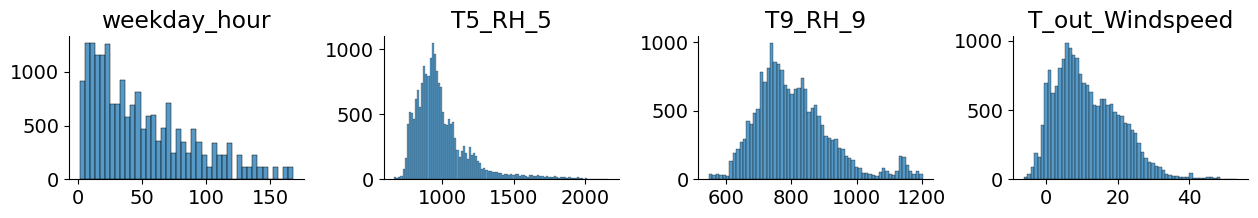

In [14]:
features = itemgetter(1, 7, 10, 12)(enhancer.interaction_features_)
histplots_grid(1, 4, enhanced_data, features=features)

In [15]:
enhanced_data[["T_out_Windspeed"]] = (enhanced_data[["T_out_Windspeed"]]
                                      + np.abs(enhanced_data[["T_out_Windspeed"]].min()))
enhanced_data[["T5_RH_5", "T_out_Windspeed"]] = np.log1p(enhanced_data[["T5_RH_5", "T_out_Windspeed"]])

# saving current data version (full) just in case
path = os.path.join("data", "modified_data", "enhanced_data.feather")
enhanced_data.to_feather(path)

# loading list of columns from the best previous experiment parent run
column_names_path = os.path.join("mlruns", "1", "cccaafc84bc142c08aa2a3169be672b1",
                                 "artifacts", "tmp8qfa1wps.json")
with open(column_names_path, "r") as file:
    column_names = json.load(file)

X_train, X_test = return_train_test_data(enhanced_data[column_names + enhancer.interaction_features_],
                                         N_TEST,
                                         xy=False)
X_train.head(2)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,day_of_week,hour,minute,time_of_day,week_of_year,day_of_year,is_holiday,is_weekend,is_high_usage,is_empty_house,lag_Appliances_1,lag_Appliances_2,lag_Appliances_3,lag_Appliances_72,lag_Appliances_144,mov_av_Appliances_2,mov_av_Appliances_3,mov_av_Appliances_6,mov_av_Appliances_18,mov_av_Appliances_72,mov_av_Appliances_144,mov_sum_Appliances_2,mov_sum_Appliances_3,mov_sum_Appliances_6,mov_sum_Appliances_18,mov_sum_Appliances_72,mov_sum_Appliances_144,lag_lights_1,lag_lights_2,lag_lights_3,lag_lights_72,lag_lights_144,mov_av_lights_2,mov_av_lights_3,mov_av_lights_6,mov_av_lights_18,mov_av_lights_72,mov_av_lights_144,mov_sum_lights_2,mov_sum_lights_3,mov_sum_lights_6,mov_sum_lights_18,mov_sum_lights_72,mov_sum_lights_144,hour_min,weekday_hour,weekday_timeofday,T1_RH_1,T2_RH_2,T3_RH_3,T4_RH_4,T5_RH_5,T7_RH_7,T8_RH_8,T9_RH_9,T_out_RH_out,T_out_Windspeed
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-13 17:00:00,4.11,0.00,20.07,42.83,19.00,42.42,19.79,44.70,19.26,42.56,17.60,50.90,18.14,37.91,18.60,45.79,17.10,43.26,6.50,744.20,75.00,2.08,29.00,2.30,36.47,36.47,Wednesday,17.00,0.00,evening,2.00,13.00,0.00,0.00,0.00,0.00,3.71,3.71,3.71,3.93,4.11,3.93,3.86,3.83,4.28,4.54,4.65,4.62,4.95,5.60,7.16,8.80,9.62,0.00,0.00,0.00,0.00,3.43,3.93,3.86,3.83,4.28,4.54,4.65,4.62,4.95,5.60,7.16,8.80,9.62,17.00,54.00,15,859.52,805.95,884.61,819.71,6.80,687.56,851.69,739.75,487.50,3.03
2016-01-13 17:10:00,4.11,2.40,20.00,42.67,19.00,42.43,19.79,44.66,19.20,42.56,17.60,50.90,18.10,37.95,18.60,45.81,17.10,43.20,6.32,744.28,76.67,2.08,30.83,2.43,22.63,22.63,Wednesday,17.00,10.00,evening,2.00,13.00,0.00,0.00,0.00,0.00,4.11,3.71,3.71,3.93,4.11,4.11,4.00,3.90,4.28,4.54,4.65,4.80,5.08,5.67,7.16,8.80,9.62,0.00,0.00,0.00,0.00,3.43,4.11,4.00,3.90,4.28,4.54,4.65,4.80,5.08,5.67,7.16,8.80,9.62,17.17,54.00,15,853.45,806.23,883.89,817.15,6.80,686.81,852.03,738.72,484.53,3.01


Updating preprocessor:

In [16]:
base_features = (['Press_mm_hg', 'Visibility', 'Tdewpoint', 'day_of_week',
                  'hour', 'minute', 'time_of_day', 'week_of_year', 'day_of_year',
                  'is_holiday', 'is_weekend', 'is_empty_house', 'is_high_usage',
                  "rv1", "rv2",]
                 + [col for col in X_train.columns
                    if ("Appliances" in col or "lights" in col)])
not_scale_features = ["is_holiday", "is_weekend", "is_empty_house", "is_high_usage"]
datetime_interaction = enhancer.interaction_features_[:3]
house_env_interaction = enhancer.interaction_features_[3:11]
weather_interaction = enhancer.interaction_features_[11:]
base_house_env =["T1", "RH_1", "T2", "RH_2", "T3", "RH_3", "T4", "RH_4",
                 "T5", "RH_5", "T7", "RH_7", "T8", "RH_8", "T9", "RH_9"]
base_weather = ["T_out", "RH_out", "Windspeed"]

preprocessor = Pipeline([
    ("selector", ColumnTransformer([
        ("base", "passthrough", base_features),
        ("house_env", ColumnSelector([]), base_house_env + house_env_interaction),
        ("weather", ColumnSelector([]), base_weather + weather_interaction),
        ("datetime", "passthrough", datetime_interaction)
        ],
                                                    remainder="drop",
                                                    verbose_feature_names_out=False)),
    ("transformer", ColumnTransformer([
        ("day", day_encoder, ["day_of_week"]),
        ("time", time_encoder, ["time_of_day"]),
        ("hour", hour_encoder, ["hour"]),
        ("pass", "passthrough", not_scale_features)
    ],
                                      remainder=StandardScaler(),
                                      verbose_feature_names_out=False)),
    ("marker", AnomaliesMarker())
])

columns_selection = {
    "regressor__preprocessor__selector__house_env__columns": [base_house_env,
                                                              house_env_interaction,
                                                              base_house_env + house_env_interaction],
    "regressor__preprocessor__selector__weather__columns": [base_weather, weather_interaction,
                                                            base_weather + weather_interaction]
}

for_linear_preprocessor = {
    "regressor__preprocessor__transformer__day": [OneHotEncoder(sparse_output=False,
                                                                drop="first"),
                                                  day_encoder],
    "regressor__preprocessor__transformer__time": [OneHotEncoder(sparse_output=False,
                                                                 drop="first"),
                                                   time_encoder],
    "regressor__preprocessor__transformer__hour": [hour_encoder, StandardScaler()],
    "transformer": target_transformations,
    **columns_selection
}

for_tree_preprocessor = {
    "regressor__preprocessor__transformer__day": [OneHotEncoder(sparse_output=False),
                                                  day_encoder],
    "regressor__preprocessor__transformer__time": [OneHotEncoder(sparse_output=False),
                                                   time_encoder],
    "regressor__preprocessor__transformer__hour": [hour_encoder, "passthrough"],
    "regressor__preprocessor__transformer__remainder": ["passthrough"],
    "transformer": target_transformations,
    **columns_selection
}

models_with_params = return_models_with_param_grids(models,
                                                    models_param_grids,
                                                    for_linear_preprocessor,
                                                    for_tree_preprocessor)

In [17]:
preprocessor.fit_transform(X_train).head(2)

,day_of_week_sin,day_of_week_cos,time_of_day_sin,time_of_day_cos,hour_sin,hour_cos,is_holiday,is_weekend,is_empty_house,is_high_usage,Press_mm_hg,Visibility,Tdewpoint,minute,week_of_year,day_of_year,rv1,rv2,Appliances,lights,lag_Appliances_1,lag_Appliances_2,lag_Appliances_3,lag_Appliances_72,lag_Appliances_144,mov_av_Appliances_2,mov_av_Appliances_3,mov_av_Appliances_6,mov_av_Appliances_18,mov_av_Appliances_72,mov_av_Appliances_144,mov_sum_Appliances_2,mov_sum_Appliances_3,mov_sum_Appliances_6,mov_sum_Appliances_18,mov_sum_Appliances_72,mov_sum_Appliances_144,lag_lights_1,lag_lights_2,lag_lights_3,lag_lights_72,lag_lights_144,mov_av_lights_2,mov_av_lights_3,mov_av_lights_6,mov_av_lights_18,mov_av_lights_72,mov_av_lights_144,mov_sum_lights_2,mov_sum_lights_3,mov_sum_lights_6,mov_sum_lights_18,mov_sum_lights_72,mov_sum_lights_144,hour_min,weekday_hour,weekday_timeofday,anomalies
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-13 17:00:00,0.97,-0.22,-0.95,0.31,-0.97,-0.26,0.00,0.00,0.00,0.00,-1.47,-0.77,-0.12,-1.46,-1.70,-1.74,0.79,0.79,-0.29,-0.58,-0.89,-0.89,-0.89,-0.56,-0.29,-0.60,-0.74,-0.86,-0.22,0.08,0.35,-0.60,-0.74,-0.86,-0.22,0.08,0.35,-0.58,-0.58,-0.58,-0.58,2.18,-0.60,-0.74,-0.86,-0.22,0.08,0.35,-0.60,-0.74,-0.86,-0.22,0.08,0.35,0.73,0.10,0.41,0
2016-01-13 17:10:00,0.97,-0.22,-0.95,0.31,-0.97,-0.26,0.00,0.00,0.00,0.00,-1.46,-0.63,-0.08,-0.88,-1.70,-1.74,-0.16,-0.16,-0.29,1.36,-0.29,-0.89,-0.89,-0.56,-0.29,-0.33,-0.53,-0.75,-0.22,0.08,0.35,-0.33,-0.53,-0.75,-0.22,0.09,0.35,-0.58,-0.58,-0.58,-0.58,2.18,-0.33,-0.53,-0.75,-0.22,0.08,0.35,-0.33,-0.53,-0.75,-0.22,0.09,0.35,0.76,0.10,0.41,0


Running experiment:

In [58]:
n_cols = X_train.shape[1]
input_example = X_test[:5]

for model, param in models_with_params:
    name = model.__class__.__name__
    
    with mlflow.start_run(run_name=f"Col_selection_{name}",
                          tags={"level": "none",
                                "test": "interactions"}):

        optimizer, metrics = optimize_params(preprocessor,
                                             model,
                                             param,
                                             X_train, y_train,
                                             TSS,
                                             n_iter=300)

        output_example = optimizer.best_estimator_.predict(input_example)
        signature = mlflow.models.infer_signature(input_example,
                                                  output_example)

        mlflow.log_params({
            **optimizer.best_params_,
            "n_cols": n_cols,
            })
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(sk_model=optimizer.best_estimator_,
                                 artifact_path="",
                                 signature=signature,
                                 registered_model_name=name)

In [29]:
runs = mlflow.search_runs(experiment_ids=["1"])

model_names_dict = {"Col_selection_ElasticNet": "ElasticNet_2",
                    "Col_selection_ExtraTreesRegressor": "ExtraTrees_2",
                    "Col_selection_HistGradientBoostingRegressor": "HistGradientBoosting_2",
                    "Col_selection_RandomForestRegressor": "RandomForest_2",
                    "Col_selection_Ridge": "Ridge_2",
                    "Col_selection_XGBRegressor": "XGBRegressor_2",
                    "ElasticNet": "ElasticNet_1",
                    "ExtraTreesRegressor": "ExtraTrees_1",
                    "HistGradientBoostingRegressor": "HistGradientBoosting_1",
                    "RandomForestRegressor": "RandomForest_1",
                    "Ridge": "Ridge_1",
                    "XGBRegressor": "XGBRegressor_1"}

new_table = (runs.groupby(["tags.mlflow.runName"])[METRICS_COLS]
                 .min()
                 .dropna(axis=0)
                 .rename(index=model_names_dict)
                 .rename(columns={name: name.split(".")[1] for name in METRICS_COLS}))
new_table.index.name = None
new_table.sort_index(axis=0)

,best_rmse,corresp_mae,corresp_medae,corresp_r2,best_mae,best_medae,best_rmse_train
ElasticNet_1,94.57,49.75,25.83,0.10,43.15,15.82,100.35
ElasticNet_2,95.13,50.69,26.97,0.11,43.58,16.22,100.32
ExtraTrees_1,91.59,50.17,25.34,0.16,42.56,15.31,80.90
ExtraTrees_2,91.83,49.81,25.13,0.17,42.65,15.56,87.51
HistGradientBoosting_1,92.54,46.33,20.18,0.13,43.15,15.51,85.99
HistGradientBoosting_2,93.07,50.13,25.18,0.14,42.82,15.71,87.85
RandomForest_1,92.73,46.86,20.24,0.13,43.31,15.43,79.95
RandomForest_2,93.03,47.92,23.40,0.14,43.50,16.14,87.58
Ridge_1,93.51,47.02,22.41,0.08,45.70,18.57,97.64
Ridge_2,95.03,50.25,25.22,0.11,44.76,17.39,98.93


The table above presents a comparison of the best model results for the first and second experiments (the suffixes _1 and _2 indicate the order of the experiments).\
The results are inconclusive, with some scores better in the first test and others in the second, though the differences are usually very slight.

### Recursive feature elimination

In this part, recursive feature elimination (RFE) was performed to check if removing any potential excess features would improve the model's results. The RFE estimators used were models from previous experiments - ExtraTreesRegressors for tree-based algorithms and Ridges for linear models. The best models for each regressor from both previous experiments were tested along with various feature selection parameters in RFE.

It was verified that all these four models correctly identified random variables (rv1, rv2) as the least important, suggesting they would perform well as estimators for RFE. **Below is an example showing the feature importances provided by the Ridge model** optimized in the 'Interaction features' test.

Suffixes _1 were applied to object names related to the first experiment (lagged and window features), and _2 to the second experiment (interaction features).

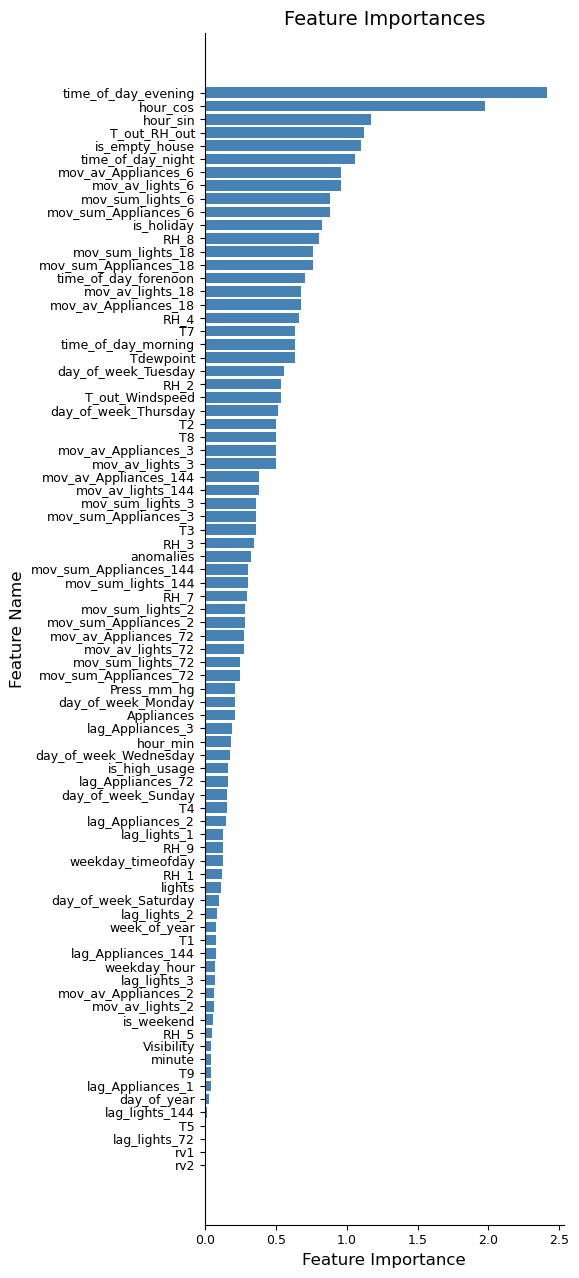

In [88]:
runs = mlflow.search_runs(experiment_ids=["1"])
linear_model_1, tree_model_1, linear_model_2, tree_model_2 = load_feature_selection_estimators(runs)

importances = np.abs(linear_model_2.regressor_.named_steps["model"].coef_)
names = linear_model_2.regressor_.named_steps["preprocessor"].get_feature_names_out()

feature_importances(importances, names)

Preparing dataframes with easily accessible artifact_uris for convenient loading of artifacts from tested models:

In [36]:
filtered_runs_1 = runs[runs["tags.test"] == "lags_windows"][["tags.mlflow.runName",
                                                             "metrics.best_rmse",
                                                             "artifact_uri"]]
models_infos_1 = (filtered_runs_1
                 .sort_values(by=["tags.mlflow.runName", "metrics.best_rmse"])
                 .dropna(axis=0)
                 .drop_duplicates(subset=["tags.mlflow.runName"], keep="first")
                 .set_index("tags.mlflow.runName"))

filtered_runs_2 = runs[runs["tags.test"] == "interactions"][["tags.mlflow.runName",
                                                             "metrics.best_rmse",
                                                             "artifact_uri"]]
models_infos_2 = (filtered_runs_2
                  .set_index("tags.mlflow.runName")
                  .rename(index={name: name.split("_")[2]
                                 for name in filtered_runs_2["tags.mlflow.runName"].values}))
models_infos_2.head(2)

,metrics.best_rmse,artifact_uri
tags.mlflow.runName,,
XGBRegressor,92.78,/home/kasia/DS/energy/Appliances_energy_prediction/mlruns/1/65a431a6abcc4c778ffa2bd4390d5018/artifacts
RandomForestRegressor,93.03,/home/kasia/DS/energy/Appliances_energy_prediction/mlruns/1/12816703d1094045b565f3e41ca869af/artifacts


To focus on precisely checking various parameters for feature selection in this experiment, grid search CV was used for the parameter grids, without modifying the preprocessors' parameters and the models' hyperparameters.\
The pipelines of the best estimators from previous experiments were decomposed to include RFE. For models from the first experiment, only the preprocessor from the estimator for RFE was used (either linear or tree-based), because different models had various sets of input features. For models from the second experiment, both the preprocessor from the estimator for RFE and from the original tested estimator were tested.

In [32]:
for i, (infos, models, common_preprocessor) in enumerate(zip([models_infos_1,
                                                              models_infos_2,
                                                              models_infos_2],
                                                             [[linear_model_1, tree_model_1],
                                                              [linear_model_2, tree_model_2],
                                                              [linear_model_2, tree_model_2]],
                                                             [True, True, False])):

    with mlflow.start_run(run_name=f"RFE_{i}",
                          tags={"level": "parent",
                                "n_iter": i,
                                "test" : "rfe"}) as parent_run:
    
        for index, row in infos.iterrows():
            model = mlflow.sklearn.load_model(row["artifact_uri"])
            name = index

            with mlflow.start_run(run_name=f"{name}",
                                  nested=True,
                                  tags={"level": "child",
                                        "n_iter": i,
                                        "test" : "rfe"}) as child_run:
        
                pipeline, X_train, importance = pipeline_recomposition_with_rfe(model,
                                                                                name,
                                                                                models,
                                                common_preprocessor=common_preprocessor)
                rfe_params = {
                    "rfe__step": [2, 5, 7, 10],
                    "rfe__n_features_to_select": [2, 5, 10, 15, 20, 25, 30, 35, 40],
                    "rfe__importance_getter": [f"regressor_.{importance}"]}
                
                optimizer, metrics = grid_search(pipeline,
                                                 rfe_params,
                                                 X_train,
                                                 y_train,
                                                 tss=TSS)

                n_cols = X_train.shape[1]
                input_example = X_train[:5]
                output_example = optimizer.best_estimator_.predict(input_example)
                signature = mlflow.models.infer_signature(input_example,
                                                          output_example)
        
                mlflow.log_params({
                    **optimizer.best_params_,
                    "n_cols": n_cols,
                    })
                mlflow.log_metrics(metrics)
                mlflow.sklearn.log_model(sk_model=optimizer.best_estimator_,
                                         artifact_path="",
                                         signature=signature,
                                         registered_model_name=name)

In [30]:
runs = mlflow.search_runs(experiment_ids=["1"])
filtered_runs = (runs[runs["tags.test"] == "rfe"][["metrics.best_rmse",
                                                   "params.rfe__step",
                                                   "params.rfe__n_features_to_select",
                                                   "tags.mlflow.runName",
                                                   "tags.n_iter",
                                                   "artifact_uri"]]
                 .sort_values(by=["metrics.best_rmse"])[:2])

filtered_runs.set_index(["tags.mlflow.runName", "tags.n_iter"]).iloc[:,:-1]

metrics.best_rmse params.rfe__step  \
tags.mlflow.runName tags.n_iter                                       
ExtraTreesRegressor 0                        91.77                7   
                    1                        91.95                5   

                                params.rfe__n_features_to_select  
tags.mlflow.runName tags.n_iter                                   
ExtraTreesRegressor 0                                         25  
                    1                                         40

Despite efforts, the best result from the first experiment was not surpassed.

However, the column sets yielding the best results (with n_iter=0 indicating origin from the first experiment and n_iter=1 from the second experiment) were chosen for the next test. This involved re-optimizing the models' hyperparameters and selecting one of these two sets. Additionally, the impact of weighting observations was explored.

In [33]:
artifact_uris = filtered_runs.artifact_uri.values

feature_set_1 = return_feature_set(artifact_uris[0])
feature_set_2 = return_feature_set(artifact_uris[1])
complete_set = list(set(feature_set_1 + feature_set_2))
len(complete_set)

## Sample weight

Since the models in previous tests had consistently underestimated high values of the target variable (typically up to 200), it was tested whether increasing the weight for observations with high values would improve this situation.

In [38]:
# mlflow.create_experiment(name="Sample_weight")
mlflow.set_experiment("Sample_weight")

<Experiment: artifact_location='/home/kasia/DS/energy/Appliances_energy_prediction/mlruns/2', creation_time=1708105540447, experiment_id='2', last_update_time=1708105540447, lifecycle_stage='active', name='Sample_weight', tags={}>

Since created feature sets included already processed features, such as two types of transformations for categorical features and sin/cos transformation for the hour, additional columns according to the different transformations used were added to the enhanced_data. During optimization at this stage, models could only choose one of the two sets (none of these transformations cause data leakage and could be performed before splitting into test and training sets).

In [39]:
path = os.path.join("data", "modified_data", "enhanced_data.feather")
enhanced_data = pd.read_feather(path)

day_encoder, time_encoder, hour_encoder, *_ = return_function_transformers()

# adding cyclical features for weekdays
transformed_day_of_week = day_encoder.transform(enhanced_data[["day_of_week"]])
enhanced_data[["day_of_week_sin", "day_of_week_cos"]] = transformed_day_of_week

# adding cyclical features for time of day
transformed_time_of_day = time_encoder.transform(enhanced_data[["time_of_day"]])
enhanced_data[["time_of_day_sin", "time_of_day_cos"]] = transformed_time_of_day

# adding cyclical features for hour
transformed_hour = hour_encoder.transform(enhanced_data[["hour"]])
enhanced_data[["hour_sin", "hour_cos"]] = transformed_hour

# one hot encoding for categorical features
enhanced_data = pd.get_dummies(enhanced_data, dtype=np.float16)

# retaining target variable for X/y split function
enhanced_data = enhanced_data[complete_set + ["Appliances_24"]]

# saving current data version just in case
path = os.path.join("data", "modified_data", "enhanced_data.feather")
enhanced_data.to_feather(path)

X_train, X_test, y_train, y_test = return_train_test_data(enhanced_data,
                                                          N_TEST,
                                                          xy=True)
X_train.head(2)

,T9,day_of_year,hour_cos,Appliances,weekday_hour,mov_av_lights_2,RH_out,T3,T5,mov_av_Appliances_144,hour_min,day_of_week_Monday,day_of_week_cos,mov_sum_Appliances_72,mov_av_lights_144,mov_sum_Appliances_144,T4,day_of_week_Tuesday,time_of_day_cos,mov_sum_Appliances_3,day_of_week_Friday,mov_sum_lights_6,mov_av_Appliances_18,mov_av_Appliances_6,lights,hour_sin,week_of_year,is_weekend,mov_av_lights_72,weekday_timeofday,mov_av_Appliances_2,time_of_day_sin,mov_sum_lights_144,mov_av_lights_6,mov_sum_lights_2,Press_mm_hg,RH_9,is_empty_house,Windspeed,RH_3,mov_sum_lights_3,mov_av_Appliances_3,day_of_week_Saturday,day_of_week_sin,mov_av_lights_3,mov_av_lights_18,mov_sum_Appliances_18
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-13 17:00:00,17.10,13.00,-0.26,4.11,54.00,3.93,75.00,19.79,17.60,4.65,17.00,0.00,-0.22,8.80,4.65,9.62,19.26,0.00,0.31,4.95,0.00,5.60,4.28,3.83,0.00,-0.97,2.00,0.00,4.54,15,3.93,-0.95,9.62,3.83,4.62,744.20,43.26,0.00,2.08,44.70,4.95,3.86,0.00,0.97,3.86,4.28,7.16
2016-01-13 17:10:00,17.10,13.00,-0.26,4.11,54.00,4.11,76.67,19.79,17.60,4.65,17.17,0.00,-0.22,8.80,4.65,9.62,19.20,0.00,0.31,5.08,0.00,5.67,4.28,3.90,2.40,-0.97,2.00,0.00,4.54,15,4.11,-0.95,9.62,3.90,4.80,744.28,43.20,0.00,2.08,44.66,5.08,4.00,0.00,0.97,4.00,4.28,7.16


Updating preprocessor:

In [217]:
to_scale_set_1 = [feature for feature in feature_set_1
                  if X_train[feature].nunique() > 2 
                  and all(
                      word not in feature for word in ["sin", "cos"])]
to_scale_set_2 = [feature for feature in feature_set_2
                  if X_train[feature].nunique() > 2 
                  and all(
                      word not in feature for word in ["sin", "cos"])]

preprocessor_1 = Pipeline([
    ("selector", ColumnSelector(feature_set_1)),
    ("transformer", ColumnTransformer([
        ("scaler", StandardScaler(), to_scale_set_1)
    ],
                                      remainder="passthrough",
                                      verbose_feature_names_out=False))])
preprocessor_2 = Pipeline([
    ("selector", ColumnSelector(feature_set_2)),
    ("transformer", ColumnTransformer([
        ("scaler", StandardScaler(), to_scale_set_2)
    ],
                                      remainder="passthrough",
                                      verbose_feature_names_out=False))
])

*_, log_transformer, sqrt_transformer = return_function_transformers()
target_transformations = [log_transformer, sqrt_transformer, None]

for_linear_preprocessor = {
    "regressor__preprocessor": [preprocessor_1, preprocessor_2],
    "transformer": target_transformations
}

for_tree_preprocessor = {
    "regressor__preprocessor": [preprocessor_1, preprocessor_2],
    "regressor__preprocessor__transformer__scaler": ["passthrough"],
    "transformer": target_transformations
}

models_with_params = return_models_with_param_grids(models,
                                                    models_param_grids,
                                                    for_linear_preprocessor,
                                                    for_tree_preprocessor)

Running experiment:

In [363]:
threshold = np.quantile(y_train, 0.90) # 210
weights = np.arange(0, 10.1, 0.5)
n_cols = X_train.shape[1]
input_example = X_test[:5]

for weight in weights:
    sample_weight = np.where(y_train > threshold, weight, 1)
    
    with mlflow.start_run(run_name=f"Weight_{weight}",
                          tags={"level": "parent",
                                "test": "weights"}) as parent_run:
        
        mlflow.log_param("weight", weight)
    
        for model, param in models_with_params:
            name = model.__class__.__name__
    
            with mlflow.start_run(run_name=f"{name}",
                                  nested=True,
                                  tags={"level": "child",
                                        "test": "weights"}) as child_run:

                optimizer, metrics = optimize_params(preprocessor_1,
                                                     model,
                                                     param,
                                                     X_train, y_train,
                                                     TSS,
                                                     n_iter=200,
                                                     fit_kw={"model__sample_weight": sample_weight})
            
                output_example = optimizer.best_estimator_.predict(input_example)
                signature = mlflow.models.infer_signature(input_example,
                                                          output_example)
        
                mlflow.log_params({
                    **optimizer.best_params_,
                    "n_cols": n_cols,
                    "weight": weight
                    })
                mlflow.log_metrics(metrics)
                mlflow.sklearn.log_model(sk_model=optimizer.best_estimator_,
                                         artifact_path="",
                                         signature=signature,
                                         registered_model_name=name)

In [381]:
runs = mlflow.search_runs(experiment_ids=["2"])
grouped_runs = (runs.groupby(["params.weight"])[METRICS_COLS]
                .mean()
                .rename(columns={name: name.split(".")[1] for name in METRICS_COLS})
                .sort_values(by=["best_rmse"]))
grouped_runs.head(3)

,best_rmse,corresp_mae,corresp_medae,corresp_r2,best_mae,best_medae,best_rmse_train
params.weight,,,,,,,
1.5,93.32,48.53,22.66,0.14,44.29,17.49,92.91
1.0,93.37,50.04,25.31,0.14,43.19,15.91,93.13
2.0,93.50,51.41,26.66,0.13,45.68,19.04,93.76


In the table above, the average results of all models for the most favorable weights applied to observations with high values of the target variable are visible. Increasing the weight to 1.5 slightly improved the results.

## Best model so far:

In [40]:
conn = sqlite3.connect("mlruns.db")

sql_query = """
SELECT 
    r.name AS run_name,
    weight.value AS weight,
    best_rmse.value AS rmse_test,
    best_rmse_train.value AS rmse_train,
    corresp_mae.value AS mae,
    corresp_medae.value AS medae,
    corresp_r2.value AS r2,
    r.artifact_uri AS artifact_uri
FROM runs r
JOIN params weight
    ON r.run_uuid = weight.run_uuid AND weight.key = 'weight'
JOIN metrics best_rmse
    ON r.run_uuid = best_rmse.run_uuid AND best_rmse.key = 'best_rmse'
JOIN metrics best_rmse_train
    ON r.run_uuid = best_rmse_train.run_uuid AND best_rmse_train.key = 'best_rmse_train'
JOIN metrics corresp_mae
    ON r.run_uuid = corresp_mae.run_uuid AND corresp_mae.key = 'corresp_mae'
JOIN metrics corresp_medae
    ON r.run_uuid = corresp_medae.run_uuid AND corresp_medae.key = 'corresp_medae'
JOIN metrics corresp_r2
    ON r.run_uuid = corresp_r2.run_uuid AND corresp_r2.key = 'corresp_r2'
ORDER BY best_rmse.value ASC
LIMIT 2
"""

artifact_info = pd.read_sql(sql_query, conn)
conn.close()

artifact_uri = artifact_info.loc[1, "artifact_uri"]
artifact_info.iloc[:,:-1]

,run_name,weight,rmse_test,rmse_train,mae,medae,r2
0,ExtraTreesRegressor,1.0,91.08,86.92,49.52,24.95,0.18
1,ExtraTreesRegressor,1.5,91.09,84.23,47.75,22.22,0.18


Due to the difference in train/test RMSE results, the question arises whether models with the best outcomes might be slightly overfitted; on the other hand, considering how the evaluation results on the full data look (below), this may stem from high variability and limited quantity in the data.

Although the model with a weight of 1 for high values was slightly better in terms of RMSE, the difference is minimal compared to the weight of 1.5, where other metrics also improved. The assessment on the test data also performs better for the model with a weight of 1.5, so it is this evaluation that is presented below.

Fitting to the full training set: 82.4



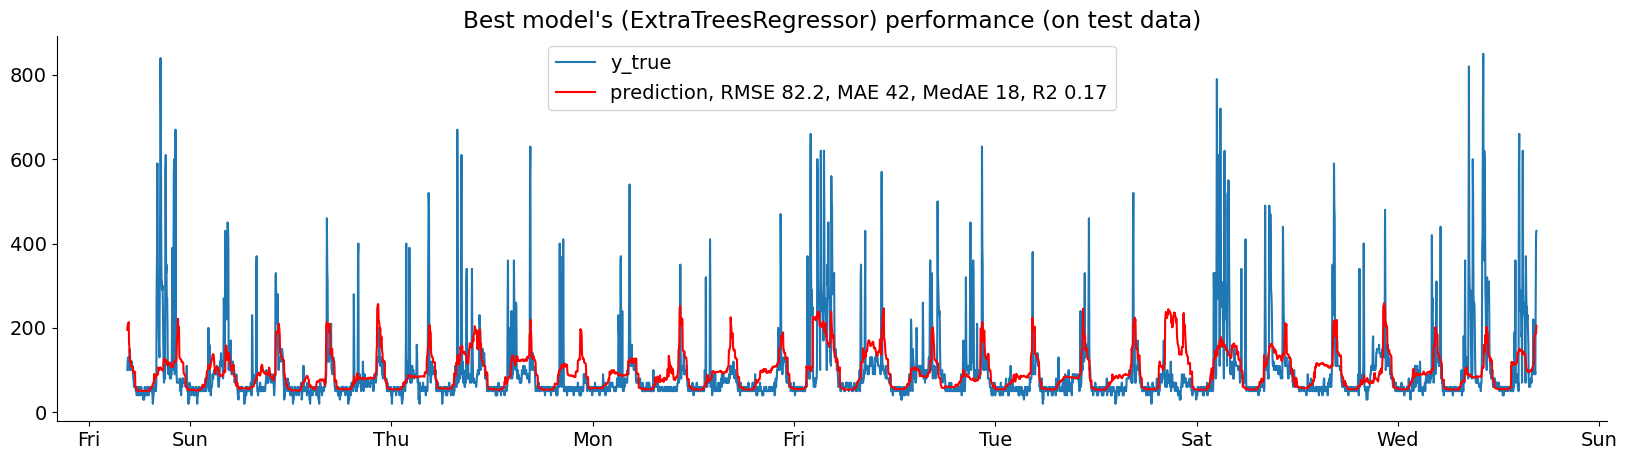

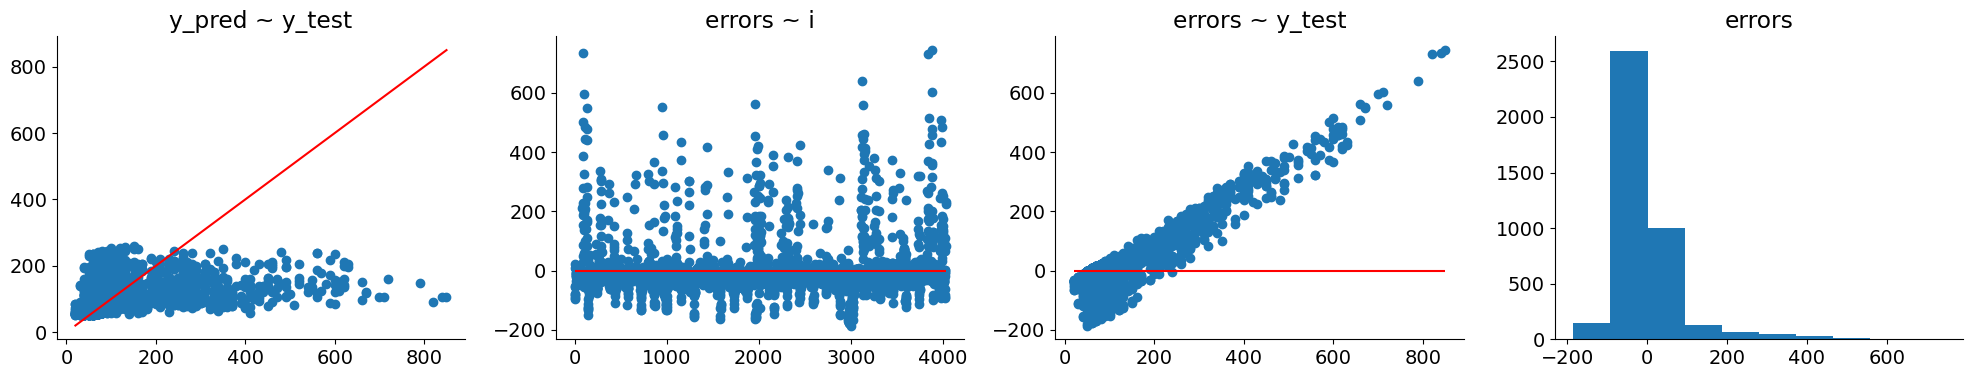

In [394]:
model = mlflow.pyfunc.load_model(artifact_uri)
column_names = model.metadata.signature.inputs.input_names()
loaded_model = mlflow.sklearn.load_model(artifact_uri)

fit_rmse = mean_squared_error(y_train, loaded_model.predict(X_train[column_names]), squared=False).round(2)
print(f"Fitting to the full training set: {fit_rmse}\n")
evaluate_model(X_test[column_names], y_test, loaded_model, loaded_model.regressor_.named_steps["model"])

The RMSE result presented in the chart is significantly better than the RMSE score obtained for this model during the optimization phase, suggests that increasing the training set size has notably improved the model's predictive capabilities.\
However, the fit to the full training set being slightly worse than to the test set predictions might indicate that the test set is easier to predict, or the training set contains more anomalies — consistent with the known data characteristics. This discrepancy could also suggest that there's still room for improvement in handling data anomalies.

Although small improvements in scores have been observed with subsequent experiments and the best score surpasses established reference points, the overall result remains unsatisfactory.

Issues:\
**y_pred vs. y_test**: The first chart compares the predicted values (y_pred) with the actual ones (y_test). The ideal prediction line (in red) illustrates where the predicted values would perfectly match the actual values. The chart reveals a tendency for the model to underestimate the larger y_test values.\
**errors vs. i**: The second chart, a scatterplot of errors plotted against the observation index, shows that while the errors are relatively randomly distributed, larger errors correspond to higher y_true values. This pattern suggests that errors increase with the actual value magnitude.\
**errors vs. y_test**: The third chart further confirms that errors amplify with rising y_test values.\
**errors histogram**: Ideally, the error distribution should be symmetrical. However, the rightward shift indicates a frequent underestimation by the model.

Efforts to mitigate these issues — including data transformations to mitigate the impact of rare values, employing models less sensitive to outliers, increasing the significance of rare values through weighting or clipping extreme values — have so far not yielded substantial improvements.